In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
from src.clr import LRFinder, OneCycleLR
import matplotlib.ticker as ticker
import pandas as pd

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(5)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## Small no multi model

In [47]:
args = load_args('../nn_configs/B/92-resnet_multi_dt.yml')

In [48]:
valdir = args['datadir']
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [52]:
args['exp_id'] = '92.1-resnet_multi_dt'

In [50]:
args['train_years'] = ['2015', '2015']

In [53]:
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [54]:
args['multi_dt'] = 1

In [55]:
dg_train, dg_valid, dg_test = load_data(**args)

In [56]:
len(dg_train), dg_train.n_samples

(137, 4374)

In [57]:
args['filters'] = [128, 128, 128, 128, 128, 35]
args['kernels'] = [7, 3, 3, 3, 3, 3]

In [58]:
model = build_resnet(input_shape = dg_train.shape, **args)

In [59]:
# model = create_multi_dt_model(model, args['multi_dt'], dg_train)

In [60]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 64, 38)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d_124 (PeriodicCo (None, 32, 64, 128)  238464      input_14[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_119 (LeakyReLU)     (None, 32, 64, 128)  0           periodic_conv2d_124[0][0]        
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 32, 64, 128)  512         leaky_re_lu_119[0][0]            
____________________________________________________________________________________________

In [61]:
loss = create_lat_mse(dg_train.data.lat)

In [62]:
args['lr']

5e-05

In [63]:
opt = keras.optimizers.Adam(1e-4)

In [64]:
model.compile(opt, loss)

In [65]:
h = model.fit(dg_train, epochs=100, validation_data=dg_valid, validation_freq=5, validation_steps=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 137 steps, validate for 10 steps
Epoch 1/100
137/137 [==============================] - 11s 77ms/step - loss: 1.9125
Epoch 2/100
137/137 [==============================] - 7s 52ms/step - loss: 0.6488
Epoch 3/100
137/137 [==============================] - 7s 51ms/step - loss: 0.4822
Epoch 4/100
137/137 [==============================] - 7s 49ms/step - loss: 0.3975
Epoch 5/100
137/137 [==============================] - 8s 58ms/step - loss: 0.3444 - val_loss: 0.1912
Epoch 6/100
137/137 [==============================] - 7s 54ms/step - loss: 0.3071
Epoch 7/100
137/137 [==============================] - 7s 50ms/step - loss: 0.2792
Epoch 8/100
137/137 [==============================] - 7s 50ms/step - loss: 0.2573
Epoch 9/100
137/137 [==============================] - 7s 49ms/step - loss: 0.2393
Epoch 10/100
137/137 [==============================] - 7s 52ms/step - loss: 0.2245 - val_loss: 0.1587
Epoch 11/100
137/137 [===============

In [66]:
preds = create_predictions(model, dg_test)

In [67]:
compute_weighted_rmse(preds.z.sel(level=500), valid.z).load()

<xarray.DataArray 'z_rmse' ()>
array(149.35683461)
Coordinates:
    level    int64 500

In [72]:
h.history['loss'][-1], h.history['val_loss'][-1]

(0.004705264355098457, 0.03995124958455563)

In [76]:
24*1000/60/60

6.666666666666667

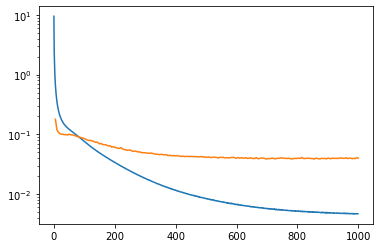

In [74]:
plt.plot(h.history['loss'])
plt.plot(np.arange(5, 1001, 5), h.history['val_loss'])
plt.yscale('log')

In [64]:
df = pd.read_csv('./train_hist.csv')

In [66]:
df.head()

,epoch,loss
0,0,9.464015
1,1,2.401408
2,2,1.448597
3,3,1.031649
4,4,0.801389
